# Assignment 1: Part Of Speech tagging

## Imports

In [ ]:
# Text pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Model definition
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense

# Data packages
import numpy as np
import pandas as pd

# System packages
import glob

# Cloning
from copy import deepcopy

# File management
import requests
import zipfile
import io
import pathlib

# Notebook visualization
from IPython.core.display import display, HTML

# Typing
from typing import Set

# For GloVe wrapper
!pip install gensim -U
import gensim
from gensim import downloader as gensloader
from gensim.models.keyedvectors import KeyedVectors

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt

## 1 - Data Pipeline

### 1.1 - Data loading
First, we load the dataset and store it into a dataframe.

In [2]:
DATASET_PATH = './dependency_treebank'  # Change if dataset already present locally
DATASET_URL = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'


def load_dataset(ds_path: str, ds_url: str) -> pd.DataFrame:
    # Check if dataset is already present, otherwise download it
    if not pathlib.Path(ds_path).exists():
        request_zip = requests.get(ds_url, stream=True)
        zip = zipfile.ZipFile(io.BytesIO(request_zip.content))
        zip.extractall()

    # Load each file into a list
    documents = []
    for file_name in sorted(glob.glob(f"{ds_path}/*.dp")):
        with open(file_name) as f:
            documents.append(f.read())

    # Convert each row of the documents into a list
    raw_df = []
    sentence_idx = 0
    for doc_idx, doc in enumerate(documents):
        rows = doc.split('\n')
        for row in rows:
            cols = row.split('\t')[:2]  # Ignore the last column
            if cols == ['']:
                sentence_idx += 1
            else:
                raw_df.append([doc_idx, sentence_idx, *cols])

    # Finally, convert the nested list into a pandas dataframe
    df = pd.DataFrame(raw_df, columns=['document', 'sentence', 'token', 'tag'])
    return df


dataset = load_dataset(DATASET_PATH, DATASET_URL)
dataset.head()

,document,sentence,token,tag
0,0,0,Pierre,NNP
1,0,0,Vinken,NNP
2,0,0,",",","
3,0,0,61,CD
4,0,0,years,NNS


### 1.2 - GloVe loading
Then, we load the GloVe embeddings (GloVe-50, to be precise).

In [3]:
EMB_DIM = 50
GLOVE_TYPE = f'glove-wiki-gigaword-{EMB_DIM}'
GLOVE_FILE = f'./glove/glove-wiki-gigaword-{EMB_DIM}.kv'


def load_glove(gl_file: str, gl_type: str) -> KeyedVectors:
    # Load local version
    path = pathlib.Path(gl_file)
    if path.exists():
        return gensim.models.KeyedVectors.load(gl_file)

    # Otherwise download and store glove
    path.parent.mkdir(parents=True, exist_ok=True)
    glove = gensloader.load(gl_type)
    glove.save(gl_file)
    return glove


glove = load_glove(GLOVE_FILE, GLOVE_TYPE)

In [4]:
# Test GloVe loading
print(f'cat = {glove["cat"]}')

cat = [ 0.45281  -0.50108  -0.53714  -0.015697  0.22191   0.54602  -0.67301
 -0.6891    0.63493  -0.19726   0.33685   0.7735    0.90094   0.38488
  0.38367   0.2657   -0.08057   0.61089  -1.2894   -0.22313  -0.61578
  0.21697   0.35614   0.44499   0.60885  -1.1633   -1.1579    0.36118
  0.10466  -0.78325   1.4352    0.18629  -0.26112   0.83275  -0.23123
  0.32481   0.14485  -0.44552   0.33497  -0.95946  -0.097479  0.48138
 -0.43352   0.69455   0.91043  -0.28173   0.41637  -1.2609    0.71278
  0.23782 ]


### 1.3 - Data visualization
One of the most important ML tasks is getting familiar with the data in order to gain a deeper insight on their structure and nature.

To do so, we define a function that displays tokens with their POS tags in a human-friendlier way.

In [ ]:
# NOTE: this could be put in its own file to keep things clean,
#       but to upload just one notebook we instead code-golfed a bit :)

# Define a mapping between POS tags, their meaning and some colors
from collections import defaultdict

tag_map = {
    'CC': ('Coordin. Conjunction', '#c18401'),
    'TO': ('“to”', '#c18401'),
    'DT': ('Determiner', '#c18401'),
    'UH': ('Interjection', '#c18401'),
    'EX': ('Existential ‘there', '#c18401'),
    'MD': ('Modal can', '#c18401'),
    'LS': ('List item marker', '#c18401'),
    'IN': ('Preposition/sub-conj', '#c18401'),
    'CD': ('Cardinal number', '#282828'),
    'FW': ('Foreign word', '#282828'),
    'NN': ('Noun, singular/mass', '#282828'),
    'NNS': ('Noun, plural', '#282828'),
    'NNP': ('Proper noun, singul.', '#282828'),
    'NNPS': ('Proper noun, plural', '#282828'),
    'JJ': ('Adjective', '#50a14f'),
    'JJR': ('Adj. comparative ', '#50a14f'),
    'JJS': ('Adj. superlative ', '#50a14f'),
    'VB': ('Verb, base form', '#e45649'),
    'VBD': ('Verb, past tense ', '#e45649'),
    'VBG': ('Verb, gerund ', '#e45649'),
    'VBN': ('Verb, past particip. ', '#e45649'),
    'VBP': ('Verb, non-3sg pres', '#e45649'),
    'VBZ': ('Verb, 3sg pres ', '#e45649'),
    'WDT': ('Wh-determiner', '#4078f2'),
    'WP': ('Wh-pronoun', '#4078f2'),
    'WP$': (' Possessive wh-', '#4078f2'),
    'WRB': ('Wh-adverb how', '#4078f2'),
    'PDT': ('Predeterminer ', '#4078f2'),
    'POS': ('Possessive ending', '#4078f2'),
    'PP': ('Personal pronoun', '#4078f2'),
    'PP$': (' Possessive pronoun ', '#4078f2'),
    'RB': ('Adverb', '#a626a4'),
    'RBR': ('Adverb, comparative', '#a626a4'),
    'RBS': ('Adverb, superlative', '#a626a4'),
    'RP': ('Particle', '#a626a4'),
}
tag_map = defaultdict(lambda: ('', '#282828'), tag_map)


def display_pos_tagging(tokens: pd.Series,
                        predicted_tags: pd.Series,
                        correct_tags: pd.Series = None,
                        limit=1000):
    # If no correct tags are passed, we ignore the "error highlighting"
    if correct_tags is None:
        correct_tags = predicted_tags

    # Limit the inputs
    tokens = tokens[:limit]
    predicted_tags = predicted_tags[:limit]
    correct_tags = correct_tags[:limit]

    # Iterate through tokens and tags, generating styled HTML based on the tags
    html_sequence = []
    for token, tag, correct in zip(tokens, predicted_tags, correct_tags):
        tag_meaning = tag_map[tag][0]
        err = 'pos-error' if tag != correct else ''
        h = f'<div class="token {tag} {err}">{token} <span class="tag">[{tag}] {tag_meaning}</span></div>'
        if tag == '.':
            h += '<div class="separator"/>'
        html_sequence.append(h)
    html_body = '<div class="pos-visualizer">'
    html_body += ' '.join(html_sequence) + '</div>'

    # Generate the style (WARNING: CSS lies ahead)
    html_style = """
	<style>
	.pos-visualizer { padding: 32px; background-color: #FEFEFE; border-left:solid 1px grey;}
	.token { position:relative; display:inline-block; font-size:16px;}
	.token .tag { 
		visibility:hidden; width: 120px; text-align:center; position:absolute;
		width: 160px; background-color: #282828; color: #fff; border-radius: 6px;
		z-index: 1; bottom: 100%; left: 50%; margin-left:-80px; font-size:12px;
	}
	.pos-error { text-decoration: underline solid #F94144;}
	.separator { margin-top:12px }
	.token:hover .tag { visibility:visible }
	"""
    html_style += '\n'.join((f'.{tag} {{color:{tag_map[tag][1]};}}'
                             for tag in predicted_tags.unique()))
    html_style += '</style>'

    # Display the HTML in the cell's output
    display(HTML(html_style + html_body))

In [ ]:
# Display some sample POS tagging (hover on text for tag meaning)
predicted_example = dataset['tag'].copy()
predicted_example[0:8] = 'CD'  # Wrong prediction example for the first 8 words
display_pos_tagging(dataset['token'],
                    predicted_example,
                    dataset['tag'],
                    limit=120)

### 1.4 - Pre-processing
Our dataset is already relatively clean; however, one point that might be worth considering is how to handle lowercase conversions. Some tokens in our dataset will be intrinsically capitalized (e.g. proper nouns, the personal pronoun "I"), whereas some other will be capitalized only because they follow a period in the sentence they occur in.

One might think of converting a token to lowercase based on its tag (e.g. if a token is a proper noun, keep it capitalized); however, to be fair, this could only be done on the training set, since in a real scenario test-set tags would be unknown.

Anyway, all these considerations hold only if GloVe contains embeddings of capitalized words; if that's not the case, every word we keep as capitalized will be classified as OOV when matched with GloVe, even when their lowercase embedding actually exists.

As it turns out, Glove does not encode capitalized words:


In [ ]:
num_capitalized = len(list(filter(lambda w: w[0].isupper(), glove.key_to_index.keys())))

print(f'GloVe-50 encodes {num_capitalized} capitalized words')

Therefore, we will be forced to convert all tokens to lowercase.

We are also interested to see which "special" tokens are encoded in GloVe, i.e. punctuation, quotation marks, and tokens such as "-LRB-" and "-RRB-", which in our dataset replace "(" and ")", respectively.

As it turns out, GloVe contains every special symbol we care about, except for tokens reserved to brackets:

In [ ]:
special_tokens = [
    *',.:;"`$#£!%/?^-()[]{}_', "''", "``", "--", "-LRB-", "-RRB-", "-LSB-",
    "-RSB-", "-LCB-", "-RCB-"
]
for st in special_tokens:
    if st not in glove:
        print(f"GloVe does not contain token {st}")

Based on the previous considerations, we convert all tokens to lowercase and replace "-LRB"-like symbols with the corresponding bracket:

In [5]:
# Convert the brackets
for token, bracket in [('-LRB-', '('), ('-RRB-', ')'), ('-LSB-', '['),
                       ('-RSB-', ']'), ('-LCB-', '{'), ('-RCB-', '}')]:
    dataset.loc[dataset.token == token, 'token'] = bracket

# Convert dataset tokens to lowercase
dataset.loc[:, 'token'] = dataset['token'].str.lower()

### 1.5 - Splitting
After pre-processing the data, we can finally split the dataset into train, validation and test.

In [6]:
ds_train = dataset[dataset['document'].lt(100)]
ds_val = dataset[dataset['document'].between(100, 149)].reset_index()
ds_test = dataset[dataset['document'].gt(149)].reset_index()

print_split = lambda df: f"{df.groupby('document').ngroups} documents, {len(df)} tokens"
print(f"""Dataset split: 
    TRAIN: {print_split(ds_train)}
    VALIDATION: {print_split(ds_val)}
    TEST: {print_split(ds_test)}
""")

Dataset split: 
    TRAIN: 100 documents, 47356 tokens
    VALIDATION: 50 documents, 31183 tokens
    TEST: 49 documents, 15545 tokens



### 1.6 - OOV Handling

#### 1.6.1 - OOV Analysis
First of all, let us take a look at how many Out-Of-Vocabulary tokens (w.r.t. GloVe) our dataset contains. In order to simulate a real-world scenario, in which test samples are not readily available at training time, we are going to check (and then handle) OOVs *incrementally*; that is, we will consider:
* **Training OOVs:** training-set tokens which are not found in GloVe.
* **Validation OOVs:** validation-set tokens which are not found in `union(`GloVe, Training OOVs`)`.
* **Test OOVs:** test-set tokens which are not found in `union(`GloVe, Training OOVs, Validation OOVs`)`.

In [8]:
def get_oov(tokens, embedding_keys):
    return set(tokens) - set(embedding_keys)

# NOTE _ TODO: gensim3 usa glove.vocab al posto di .key_to_index.keys()
glove_keys = glove.key_to_index.keys()
oov_train = get_oov(ds_train['token'].unique(), glove_keys)
oov_val = get_oov(ds_val['token'].unique(), glove_keys)
oov_test = get_oov(ds_test['token'].unique(), glove_keys)

print_oov = lambda s, d: f"{len(s)} [{len(s) / len(d['token'].unique()) * 100:.2f}%]"
print(f"""Number of OOV tokens in dataset, considering INCREMENTAL OOV EMBEDDINGS:
    TRAIN: {print_oov(oov_train, ds_train)}
    VALIDATION: {print_oov(oov_val - oov_train, ds_val)}
    TEST: {print_oov(oov_test - (oov_val | oov_train), ds_test)}
    === TOTAL: {print_oov(oov_train | oov_val | oov_test, dataset)}
""")

Number of OOV tokens in dataset, considering INCREMENTAL OOV EMBEDDINGS:
    TRAIN: 355 [4.79%]
    VALIDATION: 189 [3.49%]
    TEST: 128 [3.76%]
    === TOTAL: 672 [6.14%]



#### 1.6.2 - Adding OOVs to GloVe
We can now add OOV tokens to the GloVe vocabulary. Many strategies can be adopted to encode OOVs as vectors:
1. Static embeddings with the same vector for all OOV tokens (e.g. zeros).
2. Random embeddings. 
3. Computing an embedding as some statistic involving neighboring tokens (e.g. their mean).

Two observations can guide us in the choice of an embedding strategy:
* OOV tokens are not negligible (about 6% of the *total* dataset).
* Our GloVe embeddings will not undergo further training, therefore fixed or random embedding values will not be refined during the training process.

For the two reasons above, given an OOV token, we will compute its embedding as the mean of its left and right neighbors across all its occurrences throughout the dataset:


In [29]:
def compute_neighbor_mean(oov_token: str, df: pd.DataFrame,
                          embeddings: KeyedVectors) -> np.ndarray:
    # Find indexes where the oov token appears, and shift them by -1 +1
    indexes = df.index[df['token'] == oov_token].values
    indexes = np.concatenate((indexes - 1, indexes + 1))

    # For each oov word index, look at the left and right until a word with embedding has been found
    neighbor_embeddings = []
    for idx in indexes:
        for direction in (range(idx - 1, -1, -1), range(idx + 1, len(df))):
            for i in direction:
                tok = df['token'].iloc[i]
                if tok not in embeddings:
                    continue
                vector = embeddings[tok]
                neighbor_embeddings.append(vector)
                break

    return np.mean(neighbor_embeddings, axis=0)


def add_oovs(oov_tokens: Set, df: pd.DataFrame, 
             embeddings: KeyedVectors) -> KeyedVectors:
    # Clone the embedding (KeyedVectors does not have a clone method)
    emb_filled = deepcopy(embeddings)

    # Estimate the OOV embeddings
    keys, values = [], []
    for oov in oov_tokens:
        vector = compute_neighbor_mean(oov, df, emb_filled)
        keys.append(oov)
        values.append(vector)
    # Add the estimates to the embedding
    emb_filled.add_vectors(keys, values)
    return emb_filled


For the same reasons as discussed in the previous section, we will build our vocabulary incrementally:
1. Starting vocabulary V1 = GloVe.
2. V2 = `union(`GloVe, Training OOVs`)`.
3. V3 = `union(`V2, Validation OOVs`)`.
4. Final vocabulary V4 = `union(`V3, Test OOVs`)`.

In [13]:
# Incremental addition to OOVs to GloVe embeddings
embeddings = add_oovs(oov_train, ds_train, glove)  # add Training OOVs
embeddings = add_oovs(oov_val - oov_train, ds_val, embeddings)  # add Validation OOVs
embeddings = add_oovs(oov_test - oov_val - oov_train, ds_test, embeddings)  # add Test OOVs

In [14]:
# Test number of embeddings
print(f'Number of vectors in original GloVe:                  {len(glove)}')
print(f'Number of vectors after incremental addition of OOVs: {len(embeddings)}')

Number of vectors in original GloVe:                  400000
Number of vectors after incremental addition of OOVs: 400672


### 1.7 - Embedding Matrix

In [15]:
# Define the indexes used for word -> index -> embedding
word_index = {k: v+1 for k, v in embeddings.key_to_index.items()}  # +1 because index 0...
vocab_size = len(embeddings) + 1                                   # ...will be reserved to padding

# Define the embedding matrix
embedding_matrix = np.zeros(shape=(vocab_size, EMB_DIM))
for word, index in word_index.items():
    embedding_matrix[index] = embeddings[word]

In [16]:
# Quick test
assert np.all(embedding_matrix[embeddings.key_to_index['cat']+1] == embeddings['cat'])

### 1.8 - Data Conversion

The input data of our model could be either whole documents or single sentences contained in those documents; we will choose sentences as input data.

Tokens in each sentence will be converted to integer sequences and later fed into a static `Embedding` layer storing the matrix of Glove encodings + OOVs, which will provide the input to our model.

The corresponding tags—i.e. the output of our model—will be instead one-hot encoded. The rationale behind this choice is that tags are purely categorical data, hence encoding them as integer sequences would inject a notion of ordering into the model, which however is not reflected in the original data.

In [30]:
# Utility function
flatten_1d = lambda nested_list: [li[0] for li in nested_list]

# Convert tokens into sequences (their vocabulary indexes)
tokenizer = Tokenizer(filters='')
tokenizer.word_index = word_index
token_indexes = tokenizer.texts_to_sequences_generator(dataset['token'].array)
token_indexes = flatten_1d(token_indexes)

# Convert tags into sequences
# (as an intermediate step before one-hot encoding them)
tag_int_map = {k: v+1 for v, k in enumerate(dataset['tag'].unique())}
num_tags = len(tag_int_map) + 1
tokenizer = Tokenizer(filters='', lower=False)
tokenizer.word_index = tag_int_map
tag_indexes = tokenizer.texts_to_sequences_generator(dataset['tag'].array)
tag_indexes = flatten_1d(tag_indexes)

# Augment dataset with new data
dataset['token_index'] = token_indexes
dataset['tag_index'] = tag_indexes

# Group dataset by 'sentence', aggregating remaining data into lists
ds_sentences = dataset.groupby(['document', 'sentence']).agg(list)
ds_sentences.head()

token  \
document sentence                                                      
0        0         [pierre, vinken, ,, 61, years, old, ,, will, j...   
         1         [mr., vinken, is, chairman, of, elsevier, n.v....   
1        2         [rudolph, agnew, ,, 55, years, old, and, forme...   
2        3         [a, form, of, asbestos, once, used, to, make, ...   
         4         [the, asbestos, fiber, ,, crocidolite, ,, is, ...   

                                                                 tag  \
document sentence                                                      
0        0         [NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...   
         1         [NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...   
1        2         [NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...   
2        3         [DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...   
         4         [DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...   

                                                         token_index  \
document sentence                                                      
0        0         [5030, 400137, 2, 4979, 83, 168, 2, 44, 1430, ...   
         1         [1996, 400137, 15, 664, 4, 43651, 60024, 2, 1,...   
1        2         [9951, 34239, 2, 3069, 83, 168, 6, 158, 664, 4...   
2        3         [8, 684, 4, 14666, 443, 181, 5, 160, 5616, 701...   
         4         [1, 14666, 7677, 2, 400286, 2, 15, 7683, 18184...   

                                                           tag_index  
document sentence                                                     
0        0         [1, 1, 2, 3, 4, 5, 2, 6, 7, 8, 9, 10, 8, 5, 9,...  
         1               [1, 1, 12, 9, 10, 1, 1, 2, 8, 1, 13, 9, 11]  
1        2         [1, 1, 2, 3, 4, 5, 14, 5, 9, 10, 1, 1, 1, 1, 2...  
2        3         [8, 9, 10, 9, 17, 16, 18, 7, 1, 9, 4, 12, 16, ...  
         4         [8, 9, 9, 2, 9, 2, 12, 17, 5, 10, 19, 12, 8, 4...

Let's take a look at the distribution of sentence length in the training + validation set (leaving the test set aside) to determine what is an appropriate padded-sequence size (for batching).

99th percentile of sentence length in training + validation set: 56.0


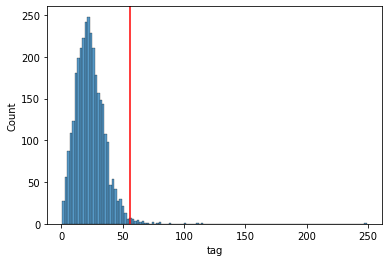

In [25]:
sentences_len = ds_sentences.query('document < 149')['tag'].transform(len)
len_quantile = sentences_len.quantile(.99)
print("99th percentile of sentence length in training + validation set:", len_quantile)

sns.histplot(sentences_len)
plt.axvline(len_quantile, color='r');

The 99th percentile suggests to trim sentences that exceed 56 tokens and pad sentences with fewer tokens, in order to prevent the few outliers from causing sentence encodings to be wastefully long.  We choose pre-padding, as it has been experimentally proven to be more effective than its counterpart post-padding.
> TODO: visto che vogliamo fare così i raffinati, a sto punto citiamo il paper come si deve.

In [31]:
pad = lambda x: pad_sequences(x, maxlen=int(len_quantile), padding='pre', truncating='pre')

def get_model_data(df: pd.DataFrame, lb=0, hb=None):
    hb = hb if hb is not None else len(df)
    df = df.query(f'{lb} <= document < {hb}')
    toks = pad(df['token_index'])
    tags = pad(df['tag_index'])
    # One-hot encode tags
    tags = to_categorical(tags, num_classes=num_tags)
    return toks, tags

# Build the data that will be fed to the model
x_train, y_train = get_model_data(ds_sentences, 0, 100)
x_val, y_val = get_model_data(ds_sentences, 100, 149)
x_test, y_test = get_model_data(ds_sentences, 149)

# Check shapes
print(f"""
X shapes [sentences x tokens]
    x_train.shape = {x_train.shape}
    x_val.shape   = {x_val.shape}
    x_test.shape  = {x_test.shape}

Y shapes [sentences x tags x one-hot-size]
    y_train.shape = {y_train.shape}
    y_val.shape   = {y_val.shape}
    y_test.shape  = {y_test.shape}
""")


X shapes [sentences x tokens]
    x_train.shape = (1963, 56)
    x_val.shape   = (1290, 56)
    x_test.shape  = (661, 56)

Y shapes [sentences x tags x one-hot-size]
    y_train.shape = (1963, 56, 46)
    y_val.shape   = (1290, 56, 46)
    y_test.shape  = (661, 56, 46)



## 2 - Model Definition

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    EMB_DIM, 
                    input_length=x_train.shape[-1],
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

2021-11-29 23:33:57.513705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 56, 50)            20033650  
                                                                 
 bidirectional (Bidirectiona  (None, 56, 64)           21248     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 56, 46)           2990      
 ibuted)                                                         
                                                                 
Total params: 20,057,888
Trainable params: 24,238
Non-trainable params: 20,033,650
_________________________________________________________________


## 3 - Training

In [ ]:
# history = model.fit(x_train, y_train,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(x_val, y_val))